# Data Analysis

In [169]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from datetime import date


# Primeras aproximaciones de análisis

data_ana = pd.read_csv("data_global.csv", sep = ',')
del(data_ana['Unnamed: 0'])
data_ana.shape

(8923, 34)

In [170]:
# Lo primero es quitar duplicados, no nos sirven ya de nada y de momento no vamos a analizar rankings
data_ana = data_ana.drop_duplicates(subset='spotify_id').copy()
data_ana.shape

(295, 34)

In [171]:
print(data_ana.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295 entries, 0 to 8922
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Position           295 non-null    int64  
 1   Track Name         295 non-null    object 
 2   Artist             295 non-null    object 
 3   Streams            295 non-null    int64  
 4   date               295 non-null    object 
 5   spotify_id         295 non-null    object 
 6   year               295 non-null    int64  
 7   Streamstotal       295 non-null    int64  
 8   album              295 non-null    object 
 9   release_date       295 non-null    object 
 10  length             295 non-null    float64
 11  popularity         295 non-null    float64
 12  acousticness       295 non-null    float64
 13  danceability       295 non-null    float64
 14  energy             295 non-null    float64
 15  instrumentalness   295 non-null    float64
 16  liveness           295 no

## PREVIO: Hacer ponderación para calcular medias respecto a los streams totales

- Añadir una columna con el peso respecto a Streams total, y respecto a su año
- Luego habría que multiplicar el valor de cada feature por el peso y sumar los resultados.

In [172]:
data_ana.head(2)

,Position,Track Name,Artist,Streams,date,spotify_id,year,Streamstotal,album,release_date,...,genre3,genre4,genre5,genre6,genre7,genre8,genre9,artist_id,artist_followers,artist_popularity
0,2,La Difícil,Bad Bunny,399788,2020-03-14,6NfrH0ANGmgBXyxgV2PeXt,2020,14996733,YHLQMDLG,2020-02-28,...,trap latino,NaN,NaN,NaN,NaN,NaN,NaN,4q3ewBCX7sLwd24euuV69X,23811758,97
61,6,Ignorantes,Bad Bunny,295813,2020-03-14,38RIEav39FGi86jppxO0du,2020,10423435,YHLQMDLG,2020-02-28,...,trap latino,NaN,NaN,NaN,NaN,NaN,NaN,4q3ewBCX7sLwd24euuV69X,23811758,97


In [173]:
# Forma rudimentaria de hacerlo, probar a hacerlo con un aplly y lambda https://thispointer.com/pandas-apply-a-function-to-single-or-selected-columns-or-rows-in-dataframe/
data_ana_2020 = data_ana[data_ana['year'] == 2020]
data_ana_2019 = data_ana[data_ana['year'] == 2019]

total_streams_2020 = data_ana_2020['Streamstotal'].sum()
total_streams_2019 = data_ana_2019['Streamstotal'].sum()

data_ana_2020['streamstotal_weights'] = data_ana_2020['Streamstotal']/total_streams_2020
data_ana_2019['streamstotal_weights'] = data_ana_2019['Streamstotal']/total_streams_2019


'''if data_ana[data_ana['year'] == 2020]:
    data_ana['streamstotal_weights'] = data_ana_2020['Streamstotal'].sum()
elif data_ana[data_ana['year'] == 2019]:
    data_ana['streamstotal_weights'] = data_ana_2019['Streamstotal'].sum()
'''
data_ana_2020_only = data_ana_2020[['year','spotify_id', 'streamstotal_weights']].copy()
data_ana_2019_only = data_ana_2019[['year','spotify_id', 'streamstotal_weights']].copy()
data_ana_sum = pd.concat([data_ana_2020_only, data_ana_2019_only], axis=0)

<ipython-input-173-bcafee2fb50f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ana_2020['streamstotal_weights'] = data_ana_2020['Streamstotal']/total_streams_2020
<ipython-input-173-bcafee2fb50f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ana_2019['streamstotal_weights'] = data_ana_2019['Streamstotal']/total_streams_2019


In [185]:
data_anam = pd.merge(data_ana, data_ana_sum, on=['year','spotify_id'])

# Comprobaciones
print(data_anam.shape)
data_anam[data_anam['Track Name'] == 'Este Segundo']
data_ana_2019[data_ana_2019['Track Name'] == 'Este Segundo']
#data_ana_2020[data_ana_2020['Track Name'] == 'La Difícil']


(295, 35)


,Position,Track Name,Artist,Streams,date,spotify_id,year,Streamstotal,album,release_date,...,genre4,genre5,genre6,genre7,genre8,genre9,artist_id,artist_followers,artist_popularity,streamstotal_weights
4438,104,Este Segundo,Alejandro Sanz,49718,2019-04-05,3rwvpuShwlJBi2X0FIHoQb,2019,85079,#ELDISCO,2019-04-04,...,latin pop,mexican pop,rock en espanol,spanish pop,NaN,NaN,5sUrlPAHlS9NEirDB8SEbF,4431016,78,0.000261


# Análisis

In [175]:
# Vemos que el número de canciones únicas en cada año registradas
data_anam.groupby(['year']).count()

,Position,Track Name,Artist,Streams,date,spotify_id,Streamstotal,album,release_date,length,...,genre4,genre5,genre6,genre7,genre8,genre9,artist_id,artist_followers,artist_popularity,streamstotal_weights
year,,,,,,,,,,,,,,,,,,,,,
2019,155,155,155,155,155,155,155,155,155,155,...,66,44,20,14,4,2,155,155,155,155
2020,140,140,140,140,140,140,140,140,140,140,...,35,21,9,2,0,0,140,140,140,140


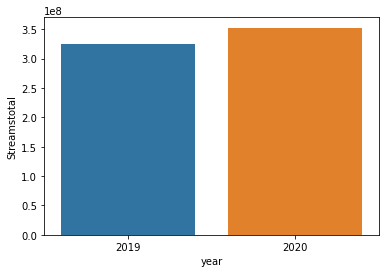

In [176]:
# Vemos que los streams total de cada año varian, pero aunque haya variación, ésta no afecta porque vamos a calcular media ponderadas
data_anam.groupby(['year']).sum()

data_anam_onlycol_streams = data_anam.loc[:, ['year', 'Streamstotal']]
data_year_streams = data_anam_onlycol_streams.groupby(['year']).sum()
data_year_streams.reset_index(inplace=True)
data_year_streams

sns.barplot(x="year", y="Streamstotal", data=data_year_streams)

In [178]:
# Vemos una aproximación de las medias sin ponderar de las features, a ver si tienen sentido, parece que si, y todas están entre 0 y 1
data_anam.groupby(['year']).mean()

,Position,Streams,Streamstotal,length,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,time_signature,artist_followers,artist_popularity,streamstotal_weights
year,,,,,,,,,,,,,,,,,,
2019,118.541935,62120.470968,2.101363e+06,0.327988,0.569935,0.290063,0.699484,0.652174,0.015948,0.164126,0.794367,0.218628,0.576601,0.433240,3.987097,8.657949e+06,79.361290,0.006452
2020,112.064286,80728.785714,2.519170e+06,0.305194,0.711714,0.248446,0.717343,0.686393,0.011939,0.141211,0.817877,0.200114,0.594129,0.410199,3.978571,7.901082e+06,78.971429,0.007143


   year  danceability
0  2019      0.699484
1  2020      0.717343


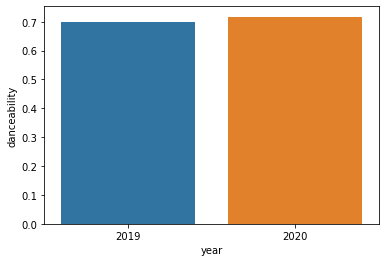

In [186]:
#Ejemplo: Comparación de danceability entre años (sin ponderar)
data_anam_onlycol_dance = data_anam.loc[:, ['year', 'danceability']]
data_year_dance = data_anam_onlycol_dance.groupby(['year']).mean()
data_year_dance.reset_index(inplace=True)

print(data_year_dance)
sns.barplot(x="year", y="danceability", data=data_year_dance)


   year  danceability  streamstotal_weights  danceability_weight
0  2019       108.420                   1.0                0.678
1  2020       100.428                   1.0                0.678


'data_anam_onlycol_dance_2020 = data_anam_onlycol_dance[data_anam_onlycol_dance[\'year\'] == 2020]\nfor value in data_anam_onlycol_dance_2020[\'danceability\']:\n    data_anam_onlycol_dance_2020["danceability_weight"] = value * data_anam_onlycol_dance_2020[\'streamstotal_weights\']\nmedia_dance_2020 = data_anam_onlycol_dance_2020["danceability_weight"].sum()\nmedia_dance_2020\n\ndata_anam_onlycol_dance_2019 = data_anam_onlycol_dance[data_anam_onlycol_dance[\'year\'] == 2019]\nfor value in data_anam_onlycol_dance_2019[\'danceability\']:\n    data_anam_onlycol_dance_2019["danceability_weight"] = value * data_anam_onlycol_dance_2019[\'streamstotal_weights\']\nmedia_dance_2019 = data_anam_onlycol_dance_2019["danceability_weight"].sum()\nmedia_dance_2019'

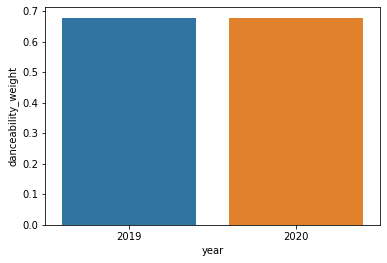

In [189]:
# Ejemplo: Comparación de danceability entre años (CON PONDERACIÓN)

data_anam_onlycol_dance = data_anam.loc[:, ['year', 'danceability', 'streamstotal_weights']]

# def media_features(feature, year)

for value in data_anam_onlycol_dance['danceability']:
    data_anam_onlycol_dance["danceability_weight"] = value * data_anam_onlycol_dance['streamstotal_weights']

media_dance = data_anam_onlycol_dance.groupby(['year']).sum()
media_dance.reset_index(inplace=True)

print(media_dance)
sns.barplot(x="year", y="danceability_weight", data=media_dance)

'''data_anam_onlycol_dance_2020 = data_anam_onlycol_dance[data_anam_onlycol_dance['year'] == 2020]
for value in data_anam_onlycol_dance_2020['danceability']:
    data_anam_onlycol_dance_2020["danceability_weight"] = value * data_anam_onlycol_dance_2020['streamstotal_weights']
media_dance_2020 = data_anam_onlycol_dance_2020["danceability_weight"].sum()
media_dance_2020

data_anam_onlycol_dance_2019 = data_anam_onlycol_dance[data_anam_onlycol_dance['year'] == 2019]
for value in data_anam_onlycol_dance_2019['danceability']:
    data_anam_onlycol_dance_2019["danceability_weight"] = value * data_anam_onlycol_dance_2019['streamstotal_weights']
media_dance_2019 = data_anam_onlycol_dance_2019["danceability_weight"].sum()
media_dance_2019'''


In [190]:
#Hay algo muy raro, no debería ser la media ponderada idéntica...
data_2020 = data_anam_onlycol_dance[data_anam_onlycol_dance['year'] == 2020]
data_2019 = data_anam_onlycol_dance[data_anam_onlycol_dance['year'] == 2019]


print(data_2020['danceability_weight'].sum())
print(data_2019['danceability_weight'].sum())

0.6779999999999999
0.6779999999999998


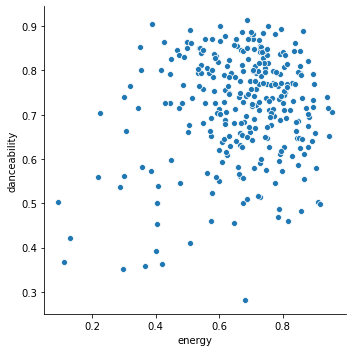

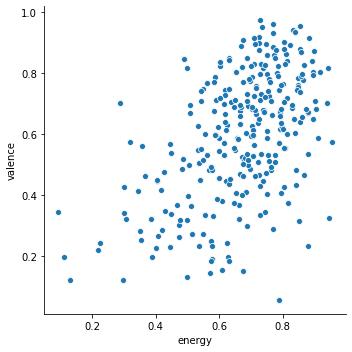

In [100]:
sns.relplot(x="energy", y="danceability", data=data_ana)
sns.relplot(x="energy", y="valence", data=data_ana)